In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
data_seed=12
mcmc_seed=123
N=1024
mcmc = np.loadtxt('FC3_mcmc/results_{}seed_{}data_{}dp.csv'.format(mcmc_seed,data_seed,N))
gt = np.loadtxt('FC3_synth/gt_map.csv').astype(np.float32)
gt =(gt[gt[:,0]==data_seed][0,1:])
gt

sampled_par,lp = mcmc[-100000:,:-1],mcmc[:,-1]
best_param = mcmc[np.argmax(lp),:-1]

In [3]:
best_param

array([ 6.65906   , -0.79919362,  0.24850702, -2.42967629,  0.87587744,
        0.38053423, -1.65551174, -0.47802877,  0.72975349, -2.04705191])

In [4]:
gt

array([ 6.5723724 , -1.3779626 , -0.05461788, -2.074227  ,  0.7858304 ,
       -1.0884377 , -2.5799398 , -0.93362224,  0.04792549, -2.3421767 ],
      dtype=float32)

In [11]:
x = [['bh','bh','lact1','lina1','sig1'],
     ['lp','lp','lact2','lina2','sig2'],
     ['lp','lp','lact3','lina3','sig3']]

In [12]:
dils = [.12,.23,.33]
def separate(x):
    return np.array(((x[0],x[1],x[2],x[3]),
                     (x[0],x[4],x[5],x[6]),
                     (x[0],x[7],x[8],x[9])))

to_hours = -np.array(((0,-1,-1,1),
                     (0,-1,-1,1),
                     (0,-1,-1,1)))*np.log(dils).reshape(-1,1)

def transform_to_hour(x): #suppose that \betas (0 and 1) are in hours, and the other in the arbirary units. Turn them all in hours
    return separate(x) + to_hours


to_arbitrary = -np.array(((1, 0, 0,0),
                             (1, 0, 0,0),
                             (1, 0, 0,0)))*np.log(dils).reshape(-1,1)

def transform_to_arbitrary(x):  #suppose that \betas (0 and 1) are in hours, and the other in the arbirary units. Turn them all to arbitrary
    return separate(x) + to_arbitrary
    

In [13]:
def separate_sampled_par(sampled_par):
    ld1,ld2,ld3 = [],[],[]
    for sp in sampled_par:
        sp_sep = transform_to_hour(sp)
        #sp_sep=separate(sp)
        for (spi,ld) in zip(sp_sep,(ld1,ld2,ld3)):
            ld.append(1.0*spi)

    return np.stack(ld1),np.stack(ld2),np.stack(ld3)

In [20]:
tranform_fun = {'ln':lambda x:x,
                'log10': lambda x:x/np.log(10),
                'real': np.exp}
tranform_pre = {'ln': r'$\ln$',
                'log10': r'$\log_{10}$',
                'real': ''}
def make_fig(sampled_par,lp,gt,transform = 'ln'):
    fig,ax = plt.subplot_mosaic(x,figsize=(16,8))
    s1,s2,s3 = separate_sampled_par(sampled_par)

    gr = ['bh','lact1','lina1','sig1']
    lab = [r'$\beta$',r'$\lambda_{act}$',r'$\lambda_{ina}$',r'$\sigma$']


    fun = tranform_fun[transform]
    s1,s2,s3 = fun(s1),fun(s2),fun(s3)
    
    prelabel = tranform_pre[transform]
    lab = [prelabel+ l for l in lab]

    gt_hour = fun(transform_to_hour(gt))

    [ax[gr[i]].hist(s1[:,i],density=True) for i in range(4)]
    [ax[gr[i]].set_xlabel(lab[i],fontsize=12) for i in range(4)]
    [ax[gr[i]].axvline(gt_hour[0,i],color='y') for i in range(4)]
    ax[gr[0]].set_ylabel(r'$\tau ={:.2f} /h $'.format((1/dils[0])))

    gr = ['lact2','lina2','sig2']
    [ax[gr[i]].hist(s2[:,i+1],density=True) for i in range(3)]
    [ax[gr[i]].set_xlabel(lab[1+i],fontsize=12) for i in range(3)]
    [ax[gr[i]].axvline(gt_hour[1,1+i],color='y') for i in range(3)]
    ax[gr[0]].set_ylabel(r'$\tau ={:.2f} /h $'.format((1/dils[1])))

    gr = ['lact3','lina3','sig3']
    [ax[gr[i]].hist(s3[:,i+1],density=True) for i in range(3)]
    [ax[gr[i]].set_xlabel(lab[1+i],fontsize=12) for i in range(3)]
    [ax[gr[i]].axvline(gt_hour[2,1+i],color='y') for i in range(3)]
    ax[gr[0]].set_ylabel(r'$\tau ={:.2f} /h $'.format((1/dils[2])))

    ax['lp'].plot(lp)
    ax['lp'].axvline(len(lp)-len(sampled_par),color='r')
    ax['lp'].set_ylim(lp.max()-100,lp.max())
    ax['lp'].set_ylabel(r'$\log$ posterior')

    
    plt.tight_layout()

In [21]:
gt_hour = transform_to_hour(gt)
gt_hour

array([[ 6.57237244, -3.49822613, -2.17488142,  0.04603644],
       [ 6.57237244, -0.68384559, -2.55811365, -1.11026387],
       [ 6.57237244, -2.04228487, -1.06073714, -1.23351405]])

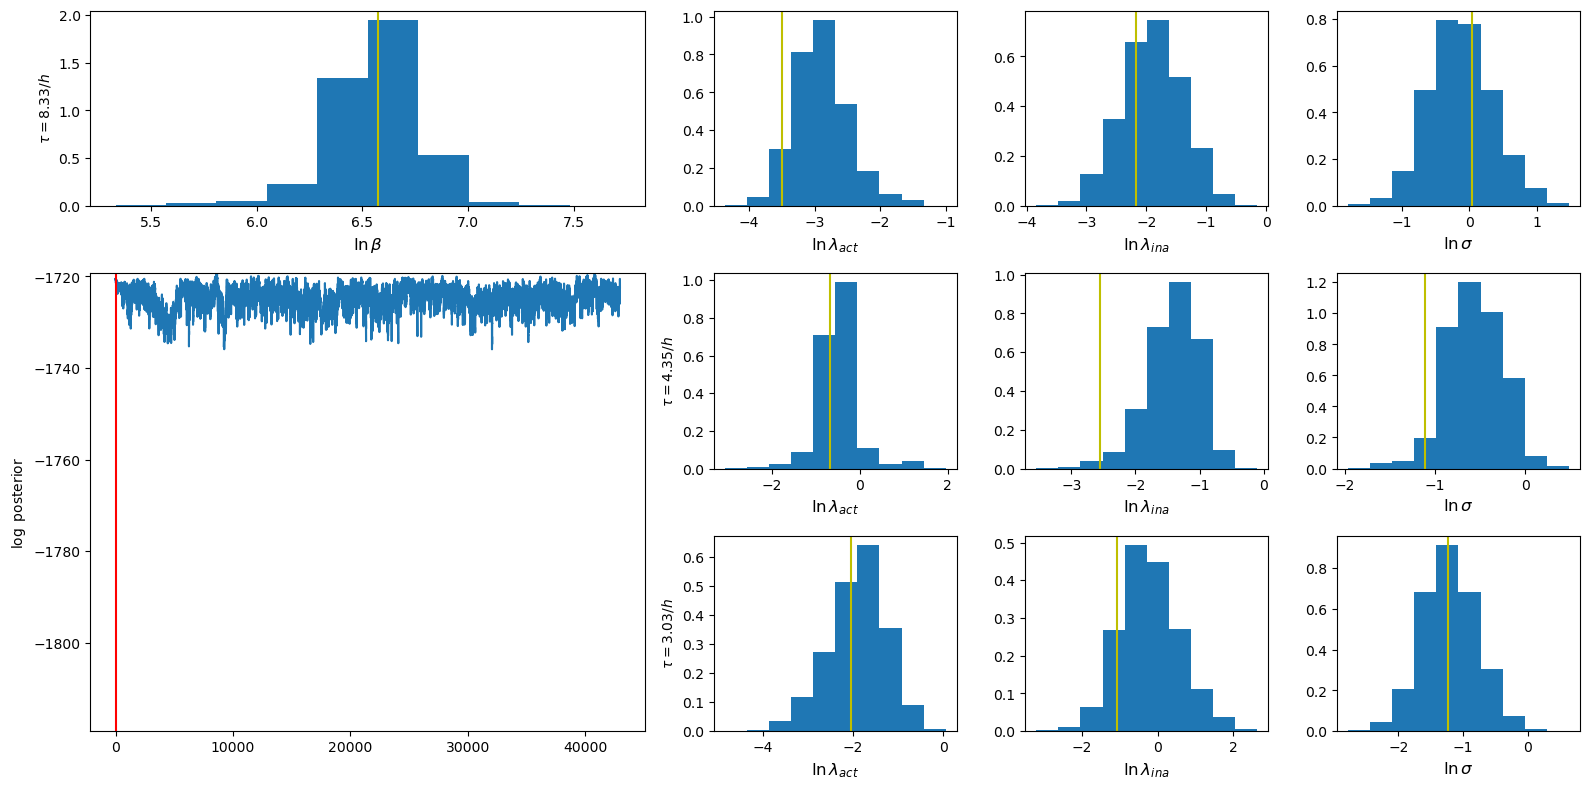

In [22]:
make_fig(sampled_par,lp,gt)


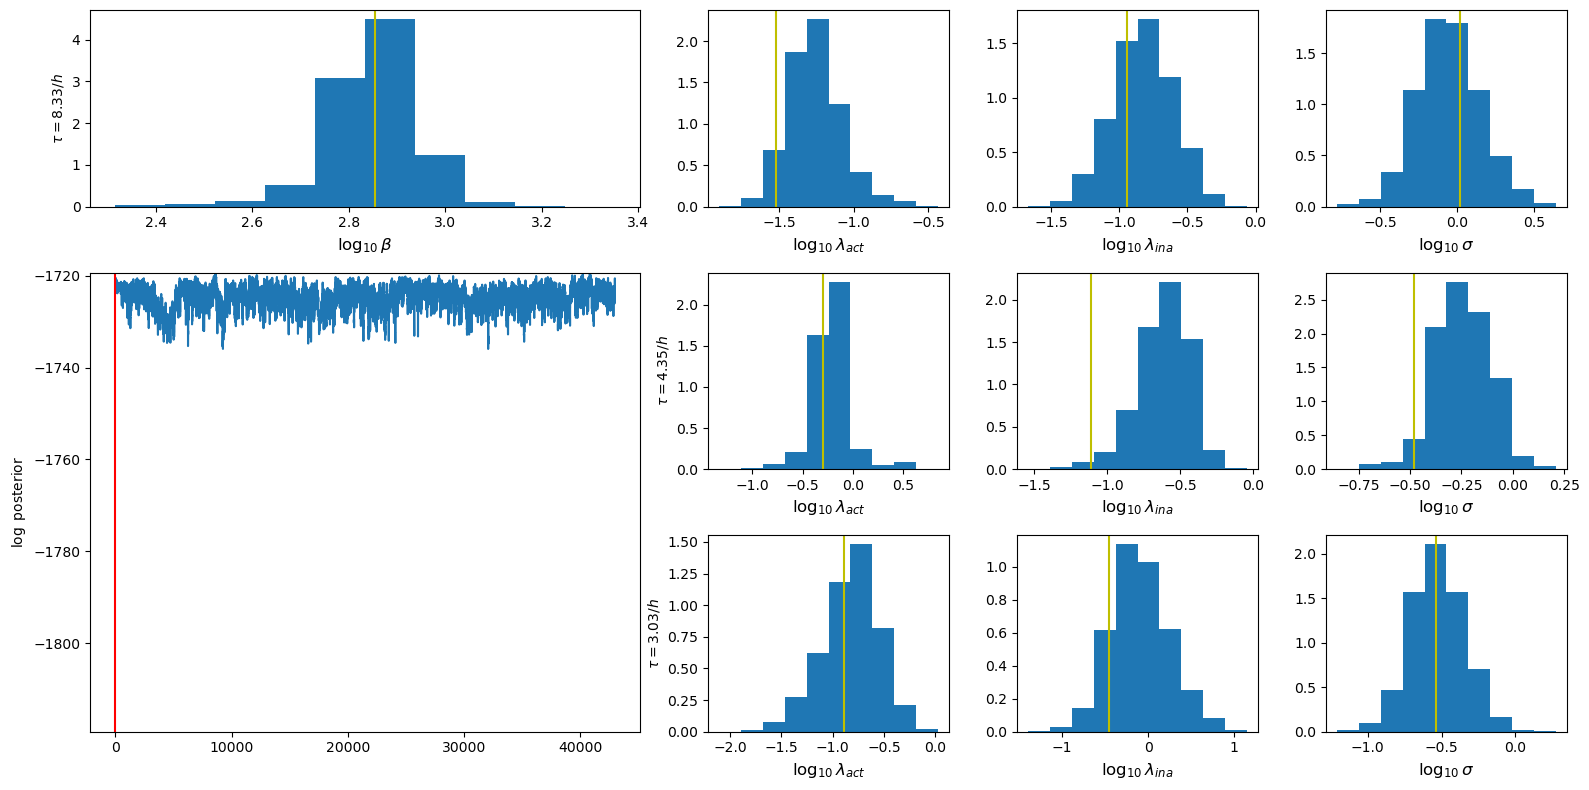

In [23]:
make_fig(sampled_par,lp,gt,'log10')
plt.savefig('main_3data_{}seed_{}data_{}dp.png'.format(mcmc_seed,data_seed,N))